In [1]:
from __future__ import annotations
import numpy as np

import os
from scipy.optimize import root

from edpyt.nano_dmft import Gfloc, Gfimp as nanoGfimp
from edpyt.dmft import Gfimp, DMFT, Converged

import matplotlib.pyplot as plt
import numpy as np


In [2]:
def distance(delta):
    global delta_prev
    delta_prev[:] = delta
    return dmft.distance(delta)


def save_sigma(sigma_diag, outputfile, npsin):
    L, ne = sigma_diag.shape
    sigma = np.zeros((ne, L, L), complex)

    def save(spin):
        for diag, mat in zip(sigma_diag.T, sigma):
            mat.flat[:: (L + 1)] = diag
        np.save(outputfile, sigma)

    for spin in range(nspin):
        save(spin)

In [3]:
U = 4.0  # Interaction
nbaths = 4
tol = 1.5
max_iter = 1000
alpha = 0.0
nspin = 1
mu = U/2
eta = 3e-2
data_folder = "../output/compute_run/"
output_folder = "../output/compute_run/model"
os.makedirs(output_folder, exist_ok=True)

occupancy_goal = np.load(f"{data_folder}/occupancies.npy")
len_active = 9
energies = np.arange(-10,10,0.01)
z_ret = energies + 1.j * eta

H_active = np.load(f"{data_folder}/hamiltonian.npy").real

beta = 1000
ne = 3000
z_mats = 1.0j * (2 * np.arange(ne) + 1) * np.pi / beta

HybMats = lambda z: 0.0

S_active = np.eye(len_active)

idx_neq = np.arange(len_active)
idx_inv = np.arange(len_active)

V = np.eye(len_active) * U


In [5]:
gfloc = Gfloc(H_active, np.eye(len_active), HybMats, idx_neq, idx_inv)
gfloc.mu = mu
nimp = gfloc.idx_neq.size
gfimp = []
for i in range(nimp):
    gfimp.append(Gfimp(nbaths, z_mats.size, V[i, i], beta))

gfimp = nanoGfimp(gfimp)

occupancy_goal = occupancy_goal[gfloc.idx_neq]

dmft = DMFT(
    gfimp,
    gfloc,
    occupancy_goal,
    max_iter=max_iter,
    tol=tol,
    adjust_mu=False,
    alpha=alpha,
    store_iterations=True,
    egrid = z_ret
)

Sigma = lambda z: np.zeros((nimp, z.size), complex)
delta = dmft.initialize(V.diagonal().mean(), Sigma, mu=mu)
delta_prev = delta.copy()


In [6]:
occupancy_goal

array([1.8584734 , 1.17283532, 0.99984953, 0.94705889, 1.4467579 ,
       1.25806845, 0.99285049, 1.17355686, 1.85227601])

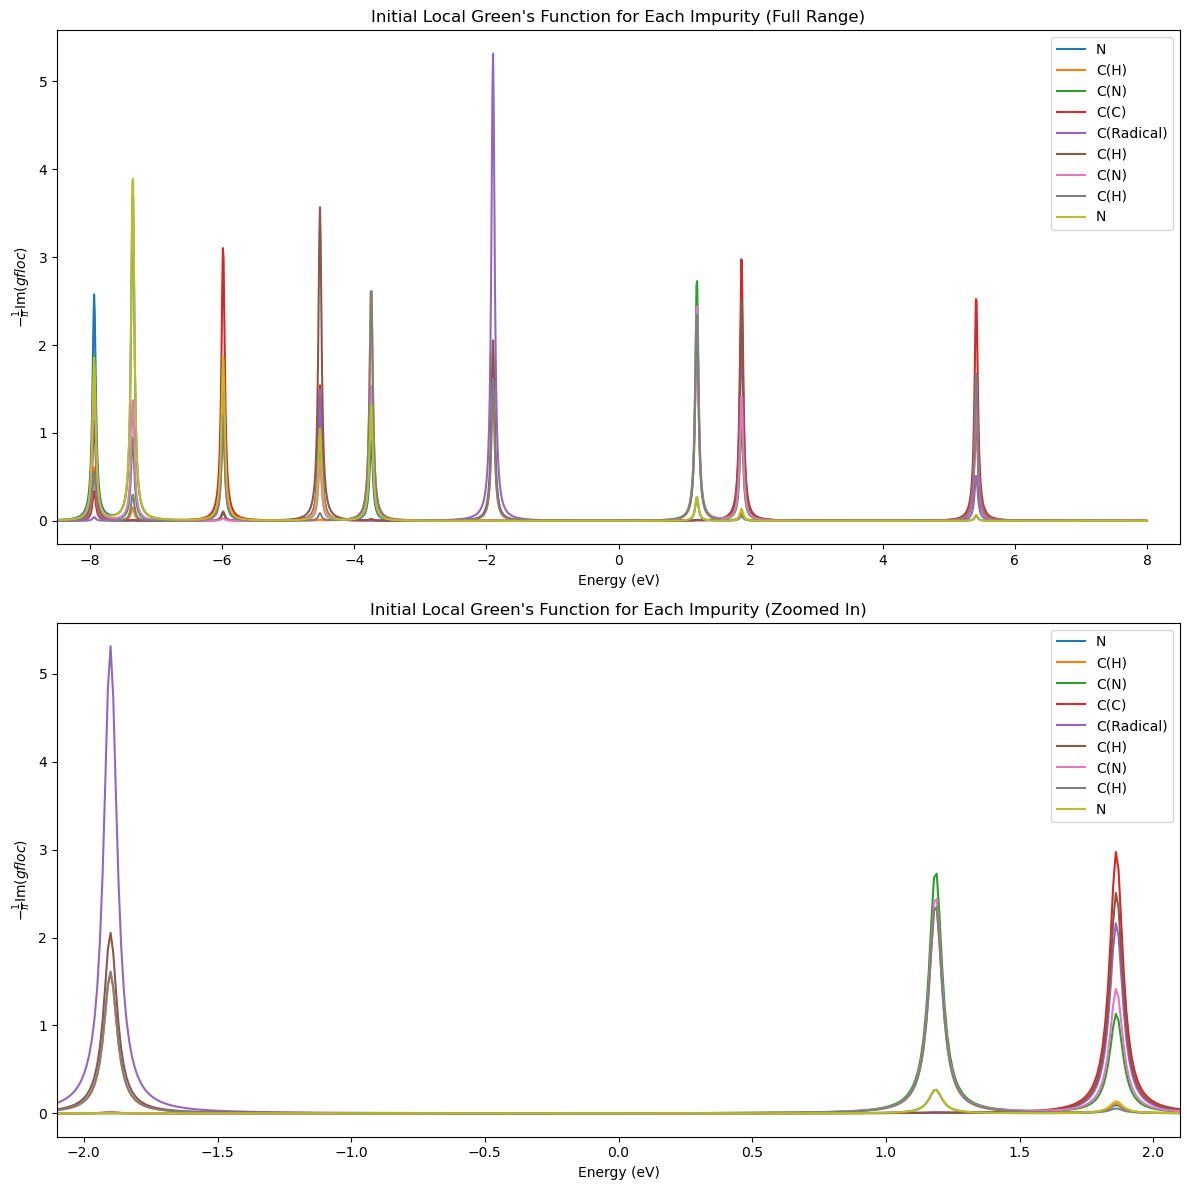

In [7]:
Ef = mu
erange = z_ret - Ef

# Calculate the Green's function for each impurity at each erange value
gfloc0 = gfloc(erange)  # Shape should be (num_impurities, erange.shape[0])

# Custom labels for each impurity
labels = ["N", "C(H)", "C(N)", "C(C)", "C(Radical)", "C(H)", "C(N)", "C(H)", "N"]

# Plotting -(1/pi) * Im(gfloc) for each impurity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Full range plot
for i, label in enumerate(labels):
    ax1.plot(np.real(erange), -(1/np.pi) * np.imag(gfloc0[i]), label=label)

ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel(r'$-\frac{1}{\pi} \operatorname{Im}(gfloc)$')
ax1.set_title('Initial Local Green\'s Function for Each Impurity (Full Range)')
ax1.set_xlim(-8.5, 8.5)
ax1.legend()

# Zoomed-in plot
for i, label in enumerate(labels):
    ax2.plot(np.real(erange), -(1/np.pi) * np.imag(gfloc0[i]), label=label)

ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel(r'$-\frac{1}{\pi} \operatorname{Im}(gfloc)$')
ax2.set_title('Initial Local Green\'s Function for Each Impurity (Zoomed In)')
ax2.set_xlim(-2.1, 2.1)
ax2.legend()

plt.tight_layout()
plt.show()


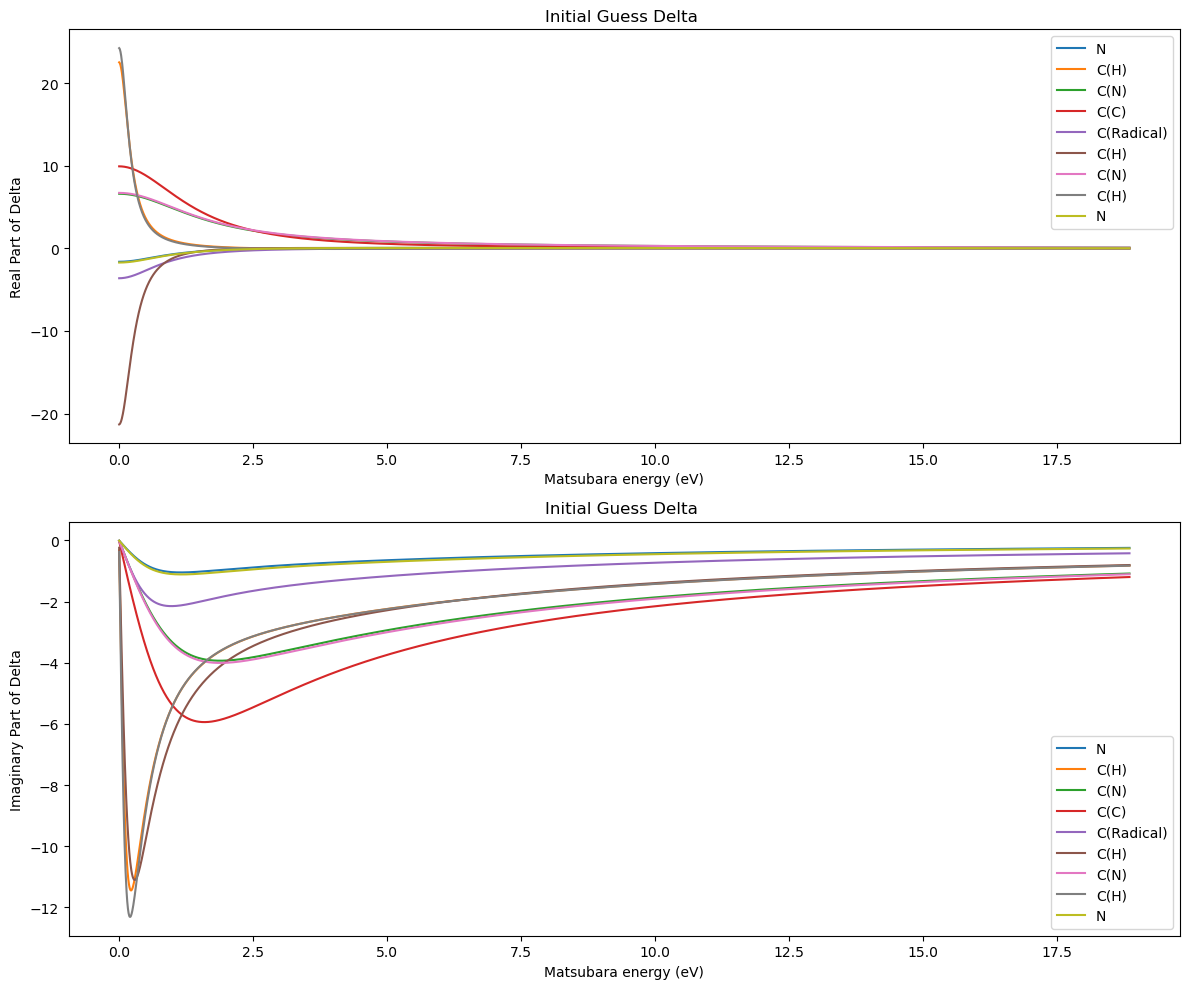

In [8]:
plt.figure(figsize=(12, 10))

# Plot real part of delta
plt.subplot(2, 1, 1)  # First subplot for the real part
for i in range(len(labels)):
    plt.plot(np.imag(z_mats), np.real(delta[i]), label=f'{labels[i]}')
plt.xlabel('Matsubara energy (eV)')
plt.ylabel('Real Part of Delta')
plt.title('Initial Guess Delta ')
plt.legend()
plt.tight_layout()

# Plot imaginary part of delta
plt.subplot(2, 1, 2)  # Second subplot for the imaginary part
for i in range(len(labels)):
    plt.plot(np.imag(z_mats), np.imag(delta[i]), label=f'{labels[i]}')
plt.xlabel('Matsubara energy (eV)')
plt.ylabel('Imaginary Part of Delta')
plt.title('Initial Guess Delta ')
plt.legend()
plt.tight_layout()

plt.show()


In [9]:
delta_new = dmft(delta)

Iteration :  0
0 9
Occupation : 11.70173 | Chemical potential : 2.00000 | Relative Error : 1.70839


In [10]:
gfimp_values = np.zeros((len_active, len(erange)), dtype=complex)

# Loop over each impurity and collect gfimp values
for i in range(len_active):
    gfimp_values[i] = gfimp[i](erange)

# Now gfimp_values has dimensions (9, 1850)
print(gfimp_values.shape)  # Should output (9, 1850)


(9, 2000)


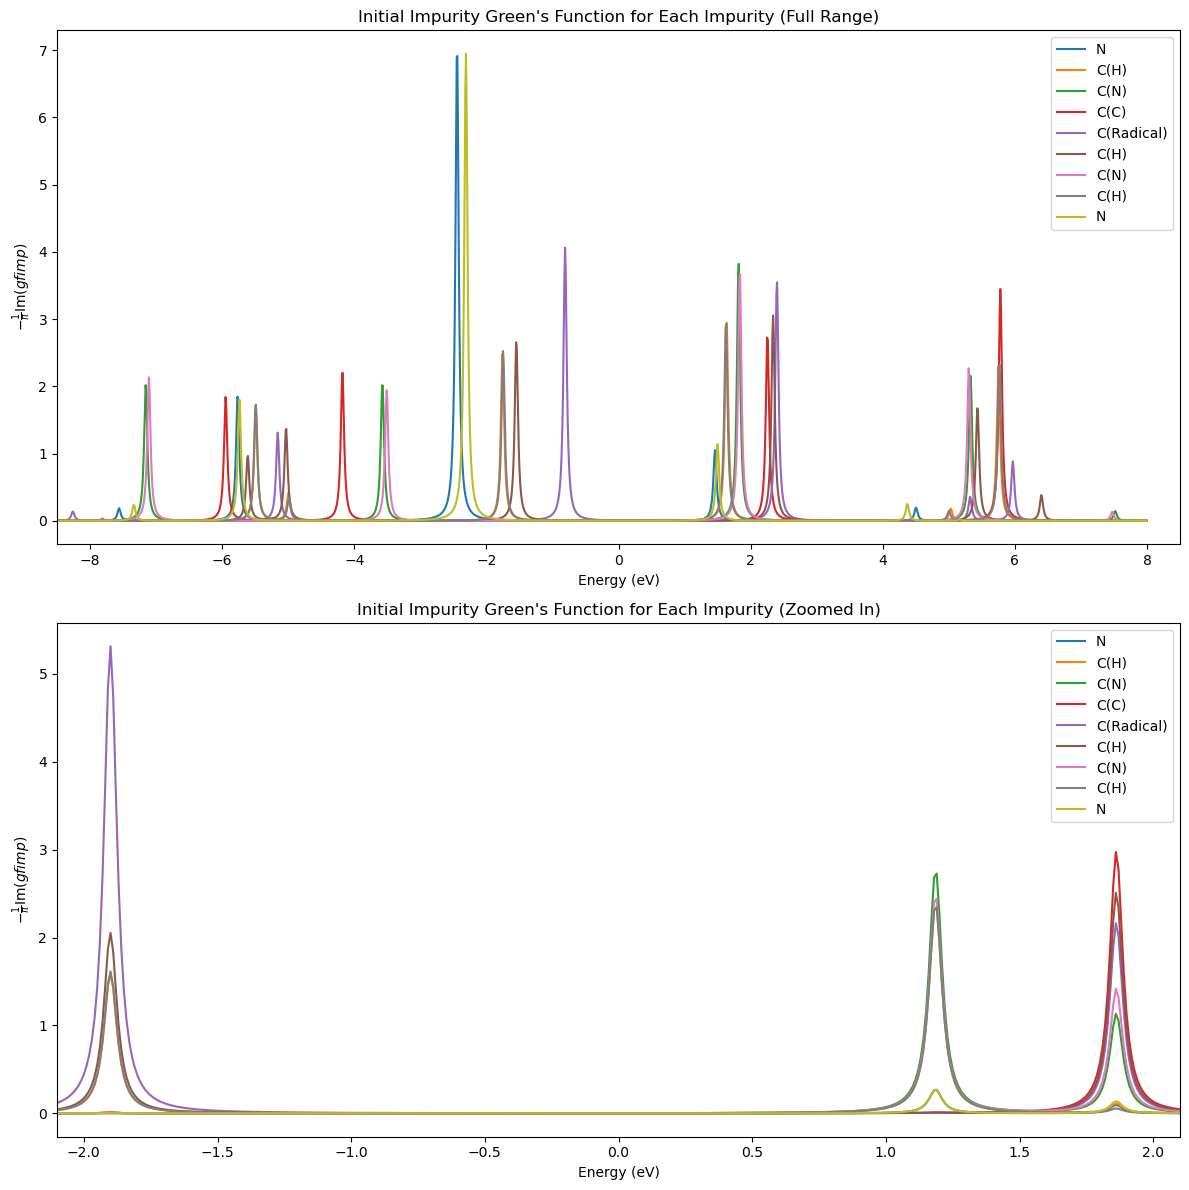

In [11]:
# Plotting -(1/pi) * Im(gfimp) for each impurity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Full range plot
for i, label in enumerate(labels):
    ax1.plot(np.real(erange), -(1/np.pi) * np.imag(gfimp_values[i]), label=label)

ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel(r'$-\frac{1}{\pi} \operatorname{Im}(gfimp)$')
ax1.set_title('Initial Impurity Green\'s Function for Each Impurity (Full Range)')
ax1.set_xlim(-8.5, 8.5)
ax1.legend()

# Zoomed-in plot
for i, label in enumerate(labels):
    ax2.plot(np.real(erange), -(1/np.pi) * np.imag(gfloc0[i]), label=label)

ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel(r'$-\frac{1}{\pi} \operatorname{Im}(gfimp)$')
ax2.set_title('Initial Impurity Green\'s Function for Each Impurity (Zoomed In)')
ax2.set_xlim(-2.1, 2.1)
ax2.legend()

plt.tight_layout()
plt.show()

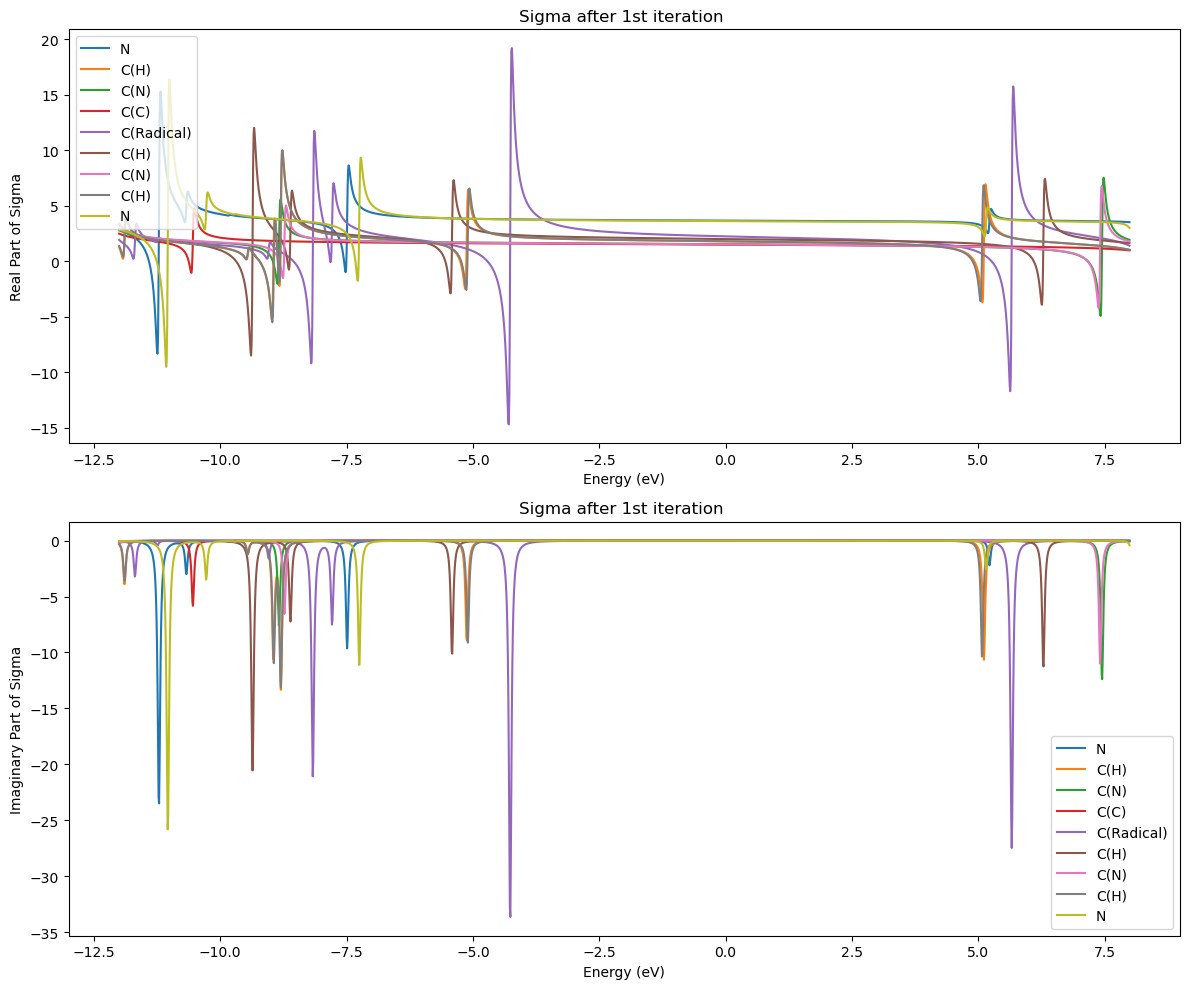

In [12]:
sigma1 = gfloc.Sigma(erange)
plt.figure(figsize=(12, 10))

# Plot real part of delta
plt.subplot(2, 1, 1)  # First subplot for the real part
for i in range(len(labels)):
    plt.plot(np.real(erange), np.real(sigma1[i]), label=f'{labels[i]}')
plt.xlabel('Energy (eV)')
plt.ylabel('Real Part of Sigma')
plt.title('Sigma after 1st iteration ')
plt.legend()
plt.tight_layout()

# Plot imaginary part of delta
plt.subplot(2, 1, 2)  # Second subplot for the imaginary part
for i in range(len(labels)):
    plt.plot(np.real(erange), np.imag(sigma1[i]), label=f'{labels[i]}')
plt.xlabel('Energy (eV)')
plt.ylabel('Imaginary Part of Sigma')
plt.title('Sigma after 1st iteration ')
plt.legend()
plt.tight_layout()

plt.show()


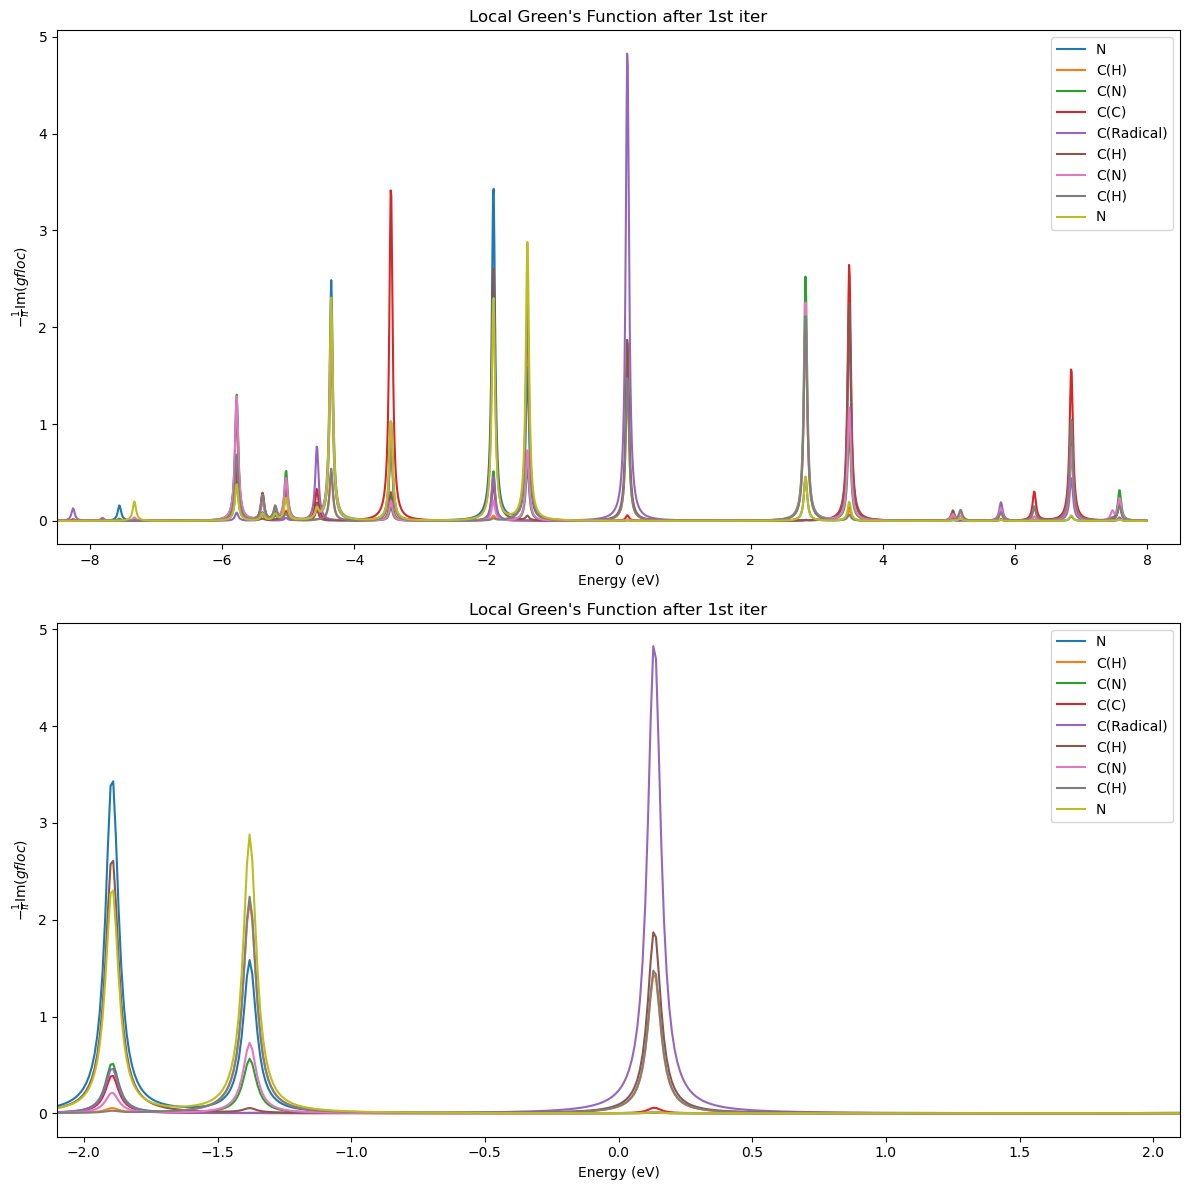

In [13]:
# Calculate the Green's function for each impurity at each erange value
gfloc1 = gfloc(erange)  # Shape should be (num_impurities, erange.shape[0])

# Plotting -(1/pi) * Im(gfloc) for each impurity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Full range plot
for i, label in enumerate(labels):
    ax1.plot(np.real(erange), -(1/np.pi) * np.imag(gfloc1[i]), label=label)

ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel(r'$-\frac{1}{\pi} \operatorname{Im}(gfloc)$')
ax1.set_title('Local Green\'s Function after 1st iter')
ax1.set_xlim(-8.5, 8.5)
ax1.legend()

# Zoomed-in plot
for i, label in enumerate(labels):
    ax2.plot(np.real(erange), -(1/np.pi) * np.imag(gfloc1[i]), label=label)

ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel(r'$-\frac{1}{\pi} \operatorname{Im}(gfloc)$')
ax2.set_title('Local Green\'s Function after 1st iter')
ax2.set_xlim(-2.1, 2.1)
ax2.legend()

plt.tight_layout()
plt.show()


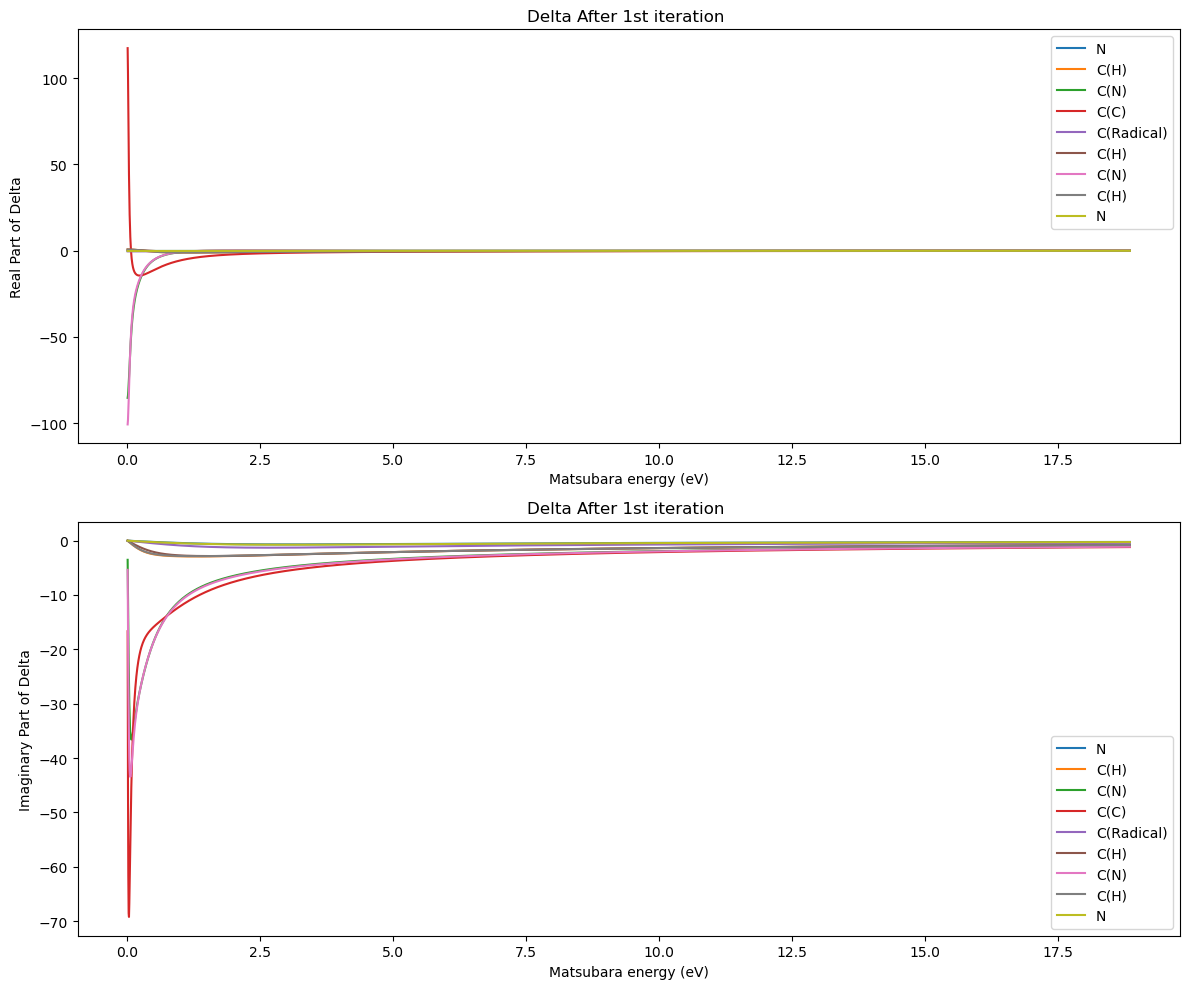

In [14]:
plt.figure(figsize=(12, 10))

# Plot real part of delta_new
plt.subplot(2, 1, 1)  # First subplot for the real part
for i in range(len_active):
    plt.plot(np.imag(z_mats), np.real(delta_new[i]), label=f'{labels[i]}')
plt.xlabel('Matsubara energy (eV)')
plt.ylabel('Real Part of Delta')
plt.title('Delta After 1st iteration ')
plt.legend()
plt.tight_layout()

# Plot imaginary part of delta_new
plt.subplot(2, 1, 2)  # Second subplot for the imaginary part
for i in range(len_active):
    plt.plot(np.imag(z_mats), np.imag(delta_new[i]), label=f'{labels[i]}')
plt.xlabel('Matsubara energy (eV)')
plt.ylabel('Imaginary Part of Delta')
plt.title('Delta After 1st iteration ')
plt.legend()
plt.tight_layout()

plt.show()


In [15]:
try:
    root(distance, delta_prev, method="broyden1")
except Converged:
    pass

np.save(f"{output_folder}/dmft_delta.npy", delta_prev)
open(f"{output_folder}/mu.txt", "w").write(str(gfloc.mu))

_Sigma = lambda z: -gfloc.mu + gfloc.Sigma(z)[idx_inv]

dmft_sigma_file = f"{output_folder}/dmft_sigma.npy"
save_sigma(_Sigma(z_ret), dmft_sigma_file, nspin)

Iteration :  1
0 9
Occupation : 11.70173 | Chemical potential : 2.00000 | Relative Error : 1.70839
Iteration :  2
0 9
Occupation : 11.70173 | Chemical potential : 2.00000 | Relative Error : 2.05770
Iteration :  3
0 9
Occupation : 11.70173 | Chemical potential : 2.00000 | Relative Error : 1.68716
Iteration :  4
0 9
Occupation : 11.70173 | Chemical potential : 2.00000 | Relative Error : 0.97553


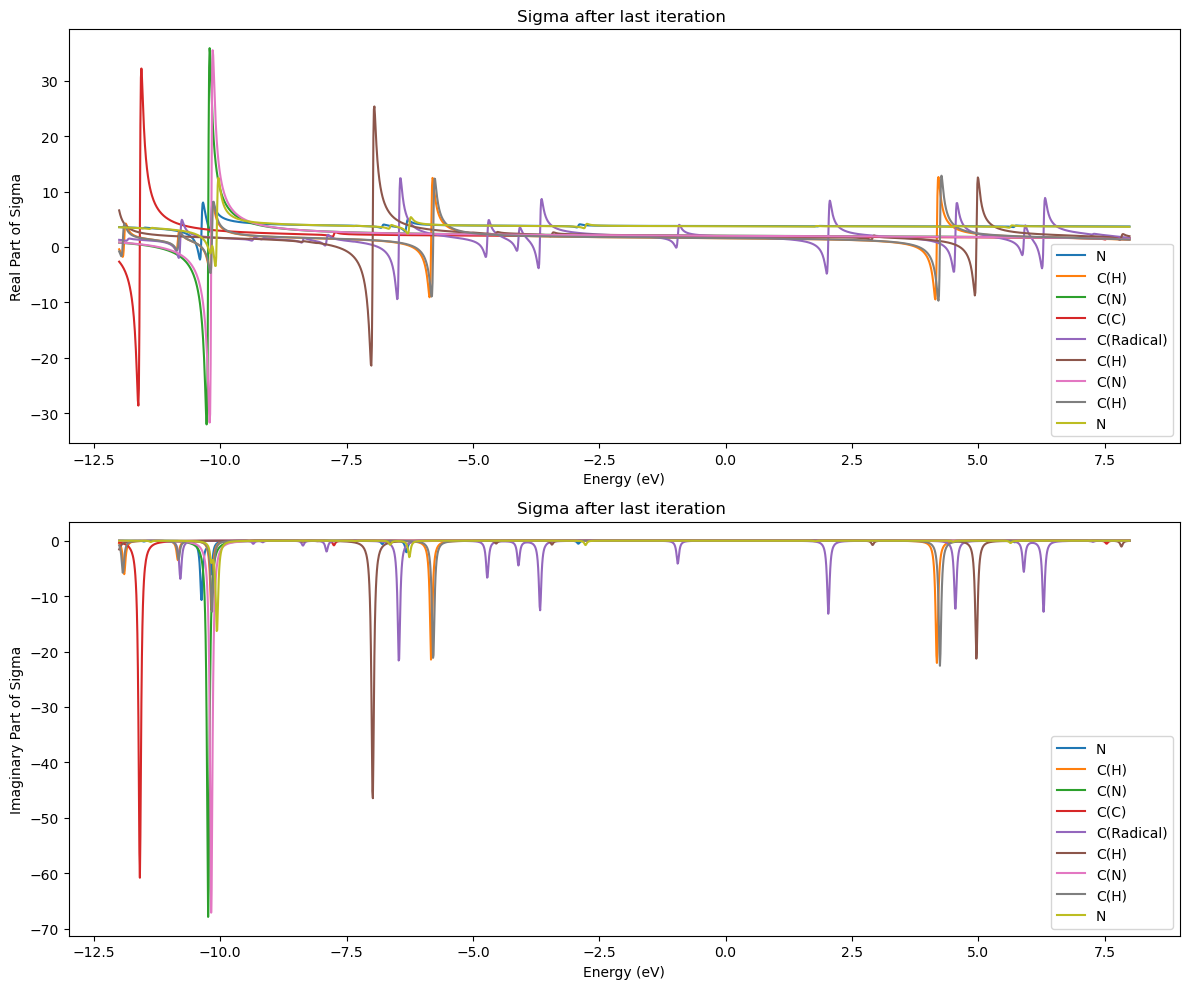

In [16]:
sigma_last = gfloc.Sigma(erange)
plt.figure(figsize=(12, 10))

# Plot real part of delta
plt.subplot(2, 1, 1)  # First subplot for the real part
for i in range(len(labels)):
    plt.plot(np.real(erange), np.real(sigma_last[i]), label=f'{labels[i]}')
plt.xlabel('Energy (eV)')
plt.ylabel('Real Part of Sigma')
plt.title('Sigma after last iteration ')
plt.legend()
plt.tight_layout()

# Plot imaginary part of delta
plt.subplot(2, 1, 2)  # Second subplot for the imaginary part
for i in range(len(labels)):
    plt.plot(np.real(erange), np.imag(sigma_last[i]), label=f'{labels[i]}')
plt.xlabel('Energy (eV)')
plt.ylabel('Imaginary Part of Sigma')
plt.title('Sigma after last iteration ')
plt.legend()
plt.tight_layout()

plt.show()


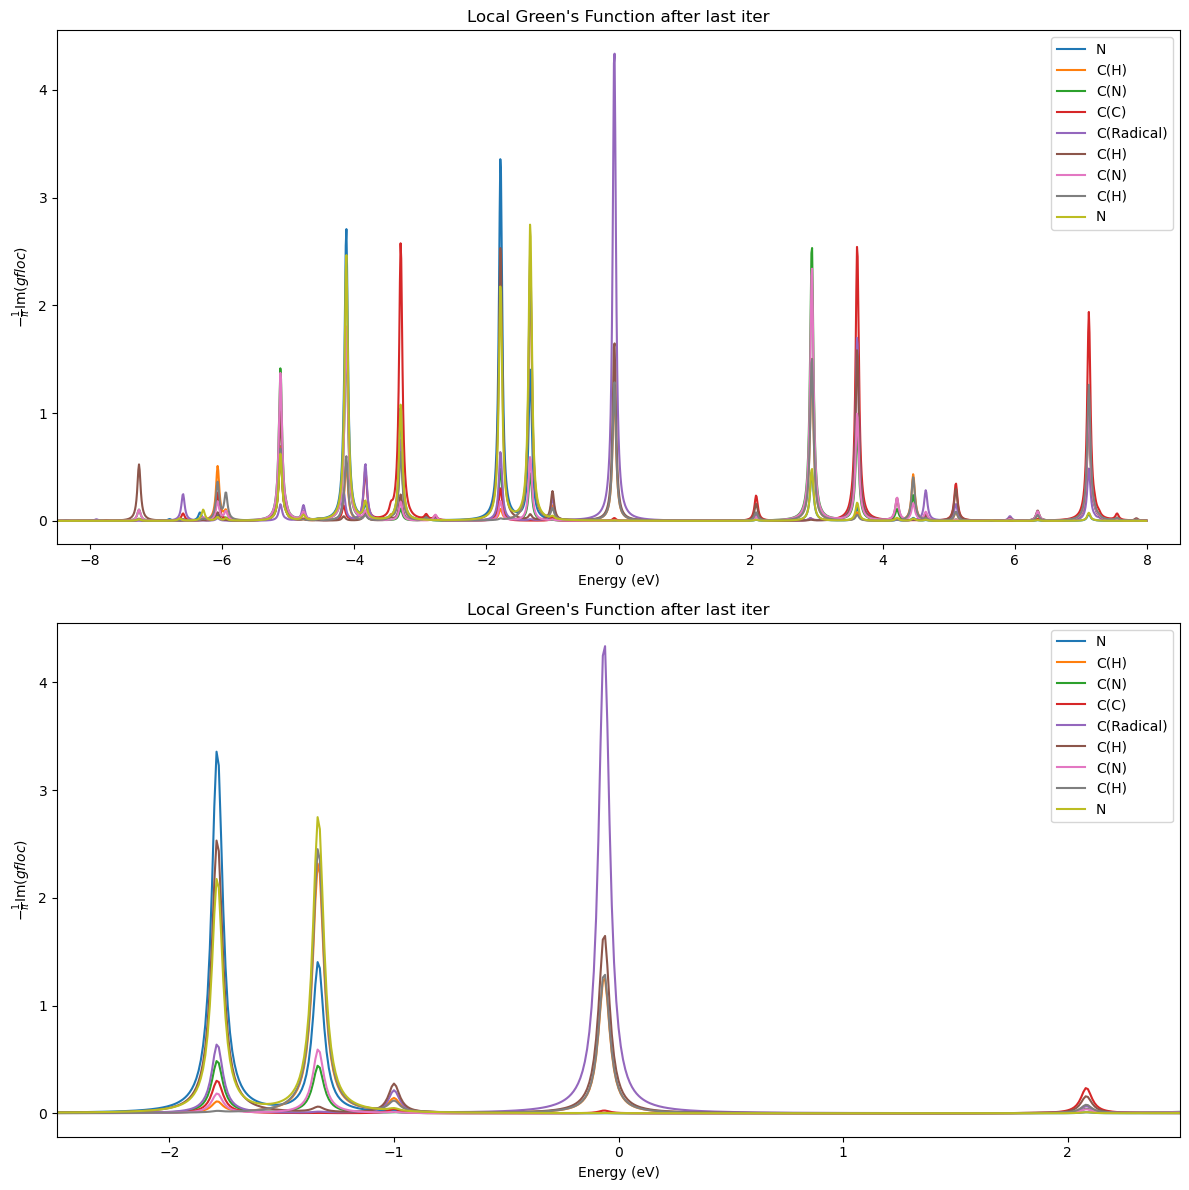

In [17]:
# Calculate the Green's function for each impurity at each erange value
gfloc_n = gfloc(erange)  # Shape should be (num_impurities, erange.shape[0])

# Plotting -(1/pi) * Im(gfloc) for each impurity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Full range plot
for i, label in enumerate(labels):
    ax1.plot(np.real(erange), -(1/np.pi) * np.imag(gfloc_n[i]), label=label)

ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel(r'$-\frac{1}{\pi} \operatorname{Im}(gfloc)$')
ax1.set_title('Local Green\'s Function after last iter')
ax1.set_xlim(-8.5, 8.5)
ax1.legend()

# Zoomed-in plot
for i, label in enumerate(labels):
    ax2.plot(np.real(erange), -(1/np.pi) * np.imag(gfloc_n[i]), label=label)

ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel(r'$-\frac{1}{\pi} \operatorname{Im}(gfloc)$')
ax2.set_title('Local Green\'s Function after last iter')
ax2.set_xlim(-2.5, 2.5)
ax2.legend()

plt.tight_layout()
plt.show()


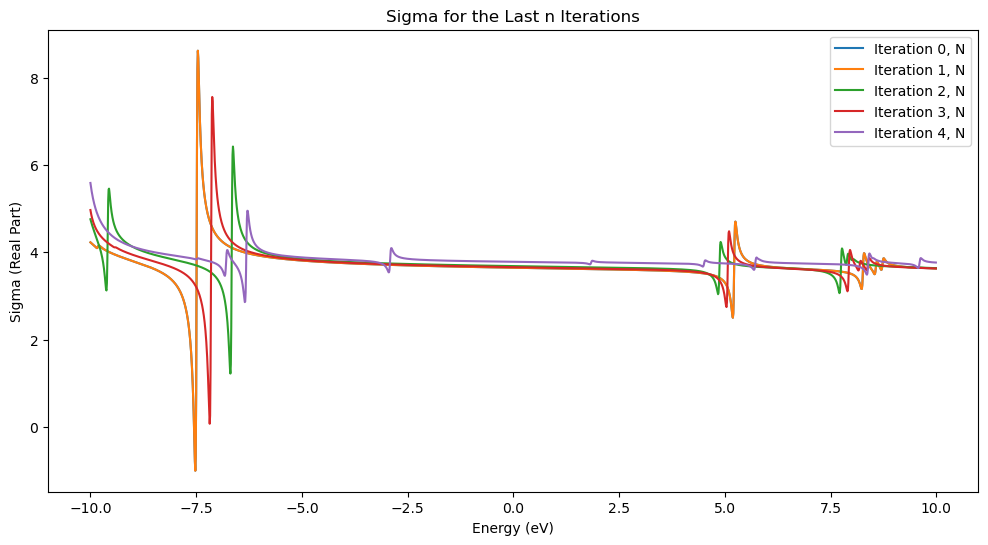

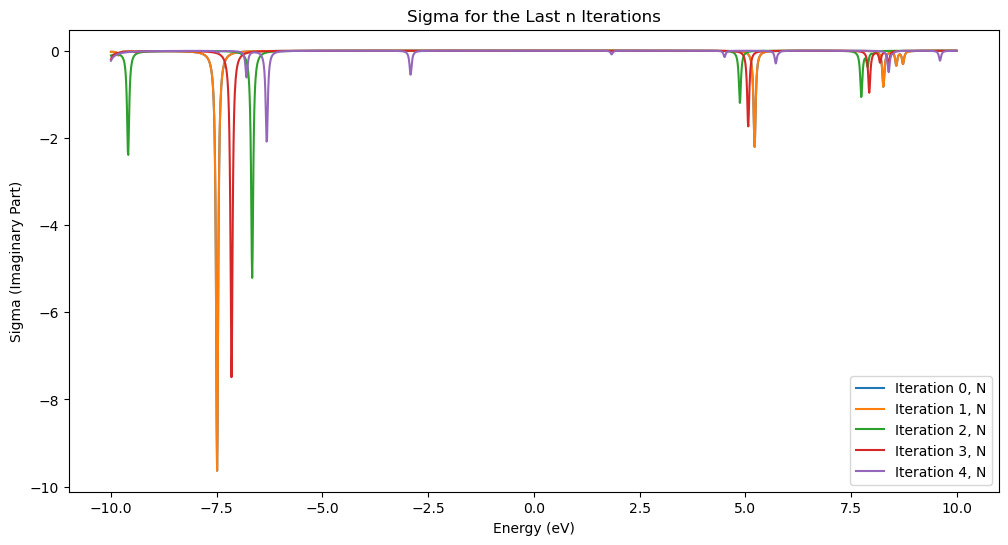

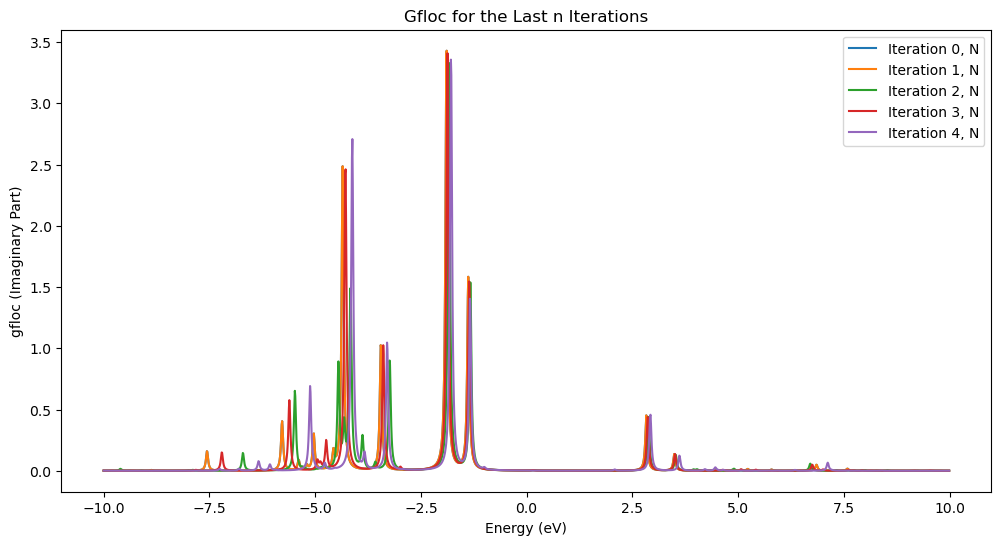

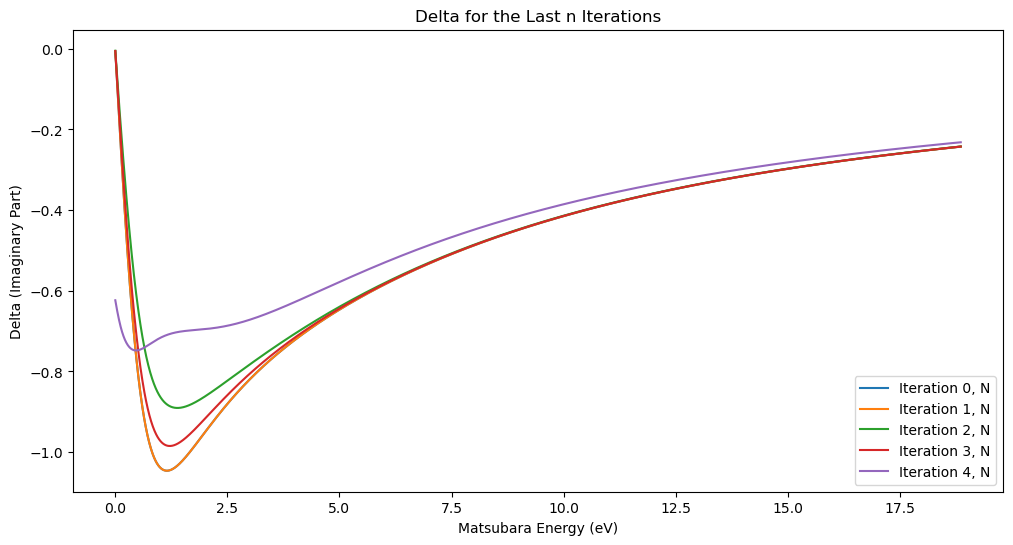

In [21]:
# After the DMFT calculation loop
n_iterations_to_plot = min(len(dmft.deltas), dmft.store_last_n)
# Plot Sigma for the last n iterations
plt.figure(figsize=(12, 6))
for i in range(n_iterations_to_plot):
    for imp in range(1):
        plt.plot(np.real(z_ret), np.real(dmft.sigmas[i][imp]), label=f'Iteration {i}, N')
plt.xlabel('Energy (eV)')
plt.ylabel('Sigma (Real Part)')
plt.legend()
plt.title('Sigma for the Last n Iterations')
plt.show()


plt.figure(figsize=(12, 6))
for i in range(n_iterations_to_plot):
    for imp in range(1):
        plt.plot(np.real(z_ret), np.imag(dmft.sigmas[i][imp]), label=f'Iteration {i}, N')
plt.xlabel('Energy (eV)')
plt.ylabel('Sigma (Imaginary Part)')
plt.legend()
plt.title('Sigma for the Last n Iterations')
plt.show()

# Plot gfloc for the last n iterations
plt.figure(figsize=(12, 6))
for i in range(n_iterations_to_plot):
    for imp in range(1):
        plt.plot(np.real(z_ret), -(1/np.pi) * np.imag(dmft.gflocs[i][imp]), label=f'Iteration {i}, N')
plt.xlabel('Energy (eV)')
plt.ylabel('gfloc (Imaginary Part)')
plt.legend()
plt.title('Gfloc for the Last n Iterations')
plt.show()

# Plot delta for the last n iterations
plt.figure(figsize=(12, 6))
for i in range(n_iterations_to_plot):
    for imp in range(1):
        plt.plot(np.imag(z_mats), np.imag(dmft.deltas[i][imp]), label=f'Iteration {i}, N')
plt.xlabel('Matsubara Energy (eV)')
plt.ylabel('Delta (Imaginary Part)')
plt.legend()
plt.title('Delta for the Last n Iterations')
plt.show()
